In [1]:
import os
import shutil
import json


from diffusers import DiffusionPipeline
import torch
from PIL import Image
import numpy as np
from RealESRGAN import RealESRGAN
from tqdm.notebook import tqdm

from library.clip_classifier import ClipClassfifier
from lib.img_preprocessor import ImagePreprocessor


with open('data.json', 'r') as f:
    data = json.load(f)


preprocessor = ImagePreprocessor()
    
clip_clf = ClipClassfifier(data["furniture_types"])



model_id = "yahoo-inc/photo-background-generation"
pipeline = DiffusionPipeline.from_pretrained(model_id, custom_pipeline=model_id)
device = torch.device("cuda:0")


pipeline = pipeline.to(device)


upscaler = RealESRGAN(device, scale=4)
upscaler.load_weights('weights/RealESRGAN_x4.pth', download=True)


/home/jupyter-kazancev.danil7@wb-2ede4/anaconda3/envs/anti_spam/lib/python3.10/site-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [3]:
img_path = "test_imgs/village_sofa.webp"
preproc_data = preprocessor.load_and_preprocess_img(img_path)

In [4]:
item_description = clip_clf.describe_image(preproc_data["orig_img"])
print(f"Description: {item_description}")

2024-06-11 16:04:55.882 | INFO     | lib.clip_classifier:describe_image:27 - Provided item classified as sofa which must placed outdoor


Description: {'furniture': 'sofa', 'category': 'outdoor'}


In [5]:
import matplotlib.pyplot as plt

def make_plot(img_list, fig_path):
    fig = plt.figure(figsize=(20, 20))
    assert len(img_list) % 10 == 0
    column_num = 5 
    raws_num = len(img_list) // column_num
    for i, img in enumerate(img_list):
        img = img.resize((512, 512))
        ax = fig.add_subplot(4, 5, i + 1)
        ax.set_title(f"img_number_{i + 1}")
        ax.imshow(img)
        ax.axis('off')
        
    plt.subplots_adjust(wspace=0.1, hspace=0.5)
    plt.savefig(fig_path)
    
    plt.show()  # 

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

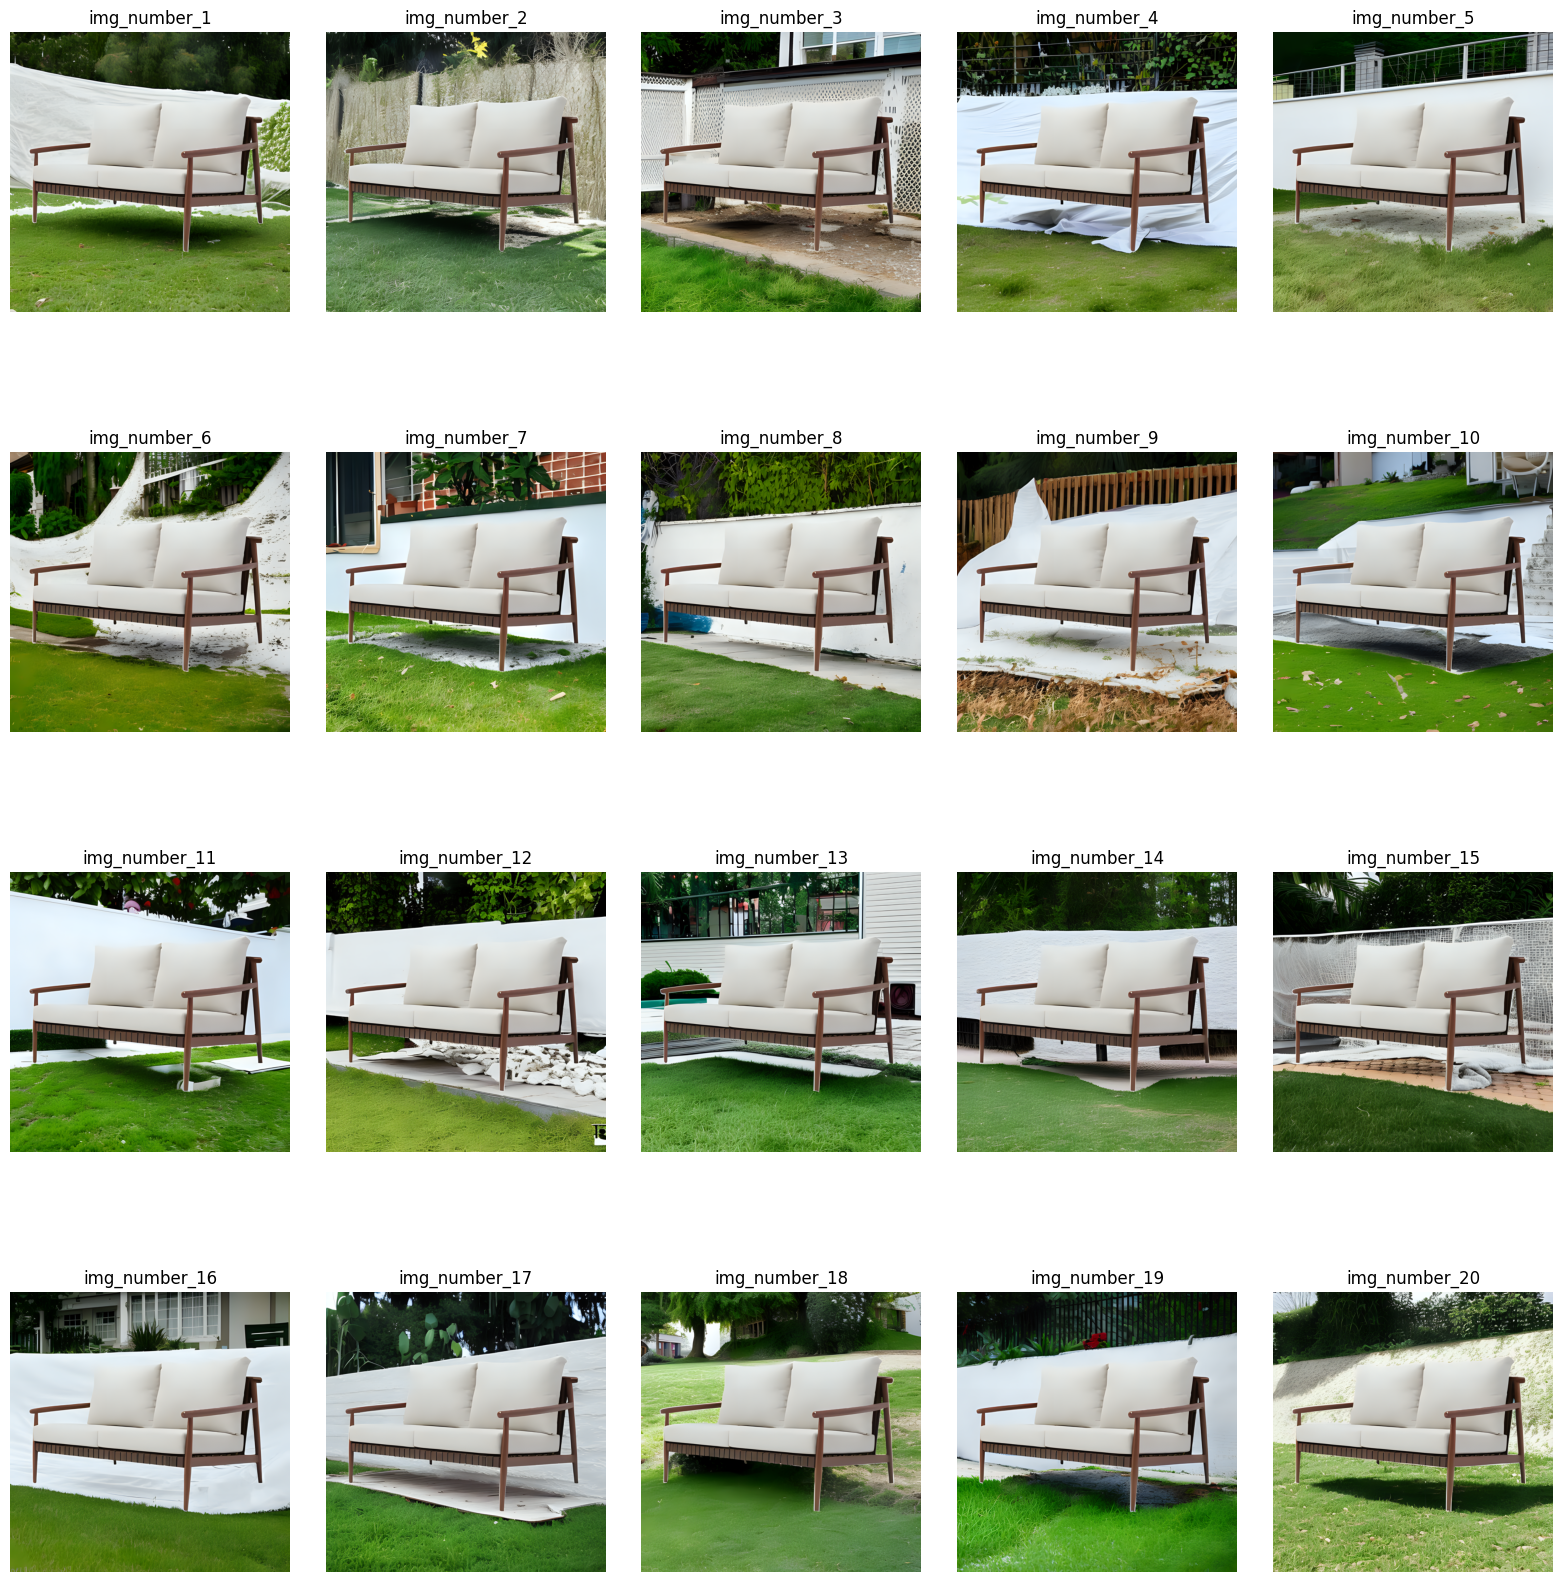

In [7]:
seed = 42
cond_scale = 1.0

generator = torch.Generator(device='cuda').manual_seed(seed)


for loc_idx, location in enumerate(data[item_description["category"]]):
    prompt = f"{item_description['furniture']} {location}"
    loc_folder = os.path.join("results", str(loc_idx))
    shutil.rmtree(loc_folder, ignore_errors=True)
    os.makedirs(loc_folder, exist_ok=True) 
    
    with torch.autocast('cuda'):
        pipe_images = pipeline(
            prompt=prompt, 
            image=preproc_data["resized_img"], mask_image=preproc_data["mask"],
            control_image=preproc_data["mask"], num_images_per_prompt=20,
            generator=generator, num_inference_steps=25,
            guess_mode=False,
            controlnet_conditioning_scale=cond_scale
        ).images

    result_images = []
    
    for idx, img in enumerate(tqdm(pipe_images)):
        sr_image = upscaler.predict(img)
        img_path = os.path.join(loc_folder, f"{idx + 1}.jpeg")
        sr_image.save(img_path, format="JPEG")
        result_images.append(sr_image)
    plot_path = os.path.join(loc_folder, "collage.png")
    make_plot(result_images, plot_path)
    

In [ ]:
len(result_images)